In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn scipy


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import svd
import zipfile
import requests
import io

In [3]:
# Define the URL and file names
db_url = "https://github.com/mkaramica/bankruptcy_prediction/blob/c030c3c2ef6529e7b27f954c7b7d2170c551ede8/archive.zip?raw=true"
db_file = "archive.zip"
database_file = "data.csv"

# Download the zipped file
response = requests.get(db_url)
with open(db_file, 'wb') as f:
    f.write(response.content)

# Unzip the file
with zipfile.ZipFile(db_file, 'r') as zip_ref:
    zip_ref.extract(database_file)

# Read the CSV file
bankruptcyDB = pd.read_csv(database_file)


In [4]:
# Overview of the data
nrows, ncols = bankruptcyDB.shape
print(f"Number of rows: {nrows}, Number of columns: {ncols}")

# Remove the 95th column if it is constant
if bankruptcyDB.iloc[:, 94].nunique() == 1:
    bankruptcyDB.drop(bankruptcyDB.columns[94], axis=1, inplace=True)

# Rename columns
bankruptcyDB.columns = [f"[{i}]" for i in range(bankruptcyDB.shape[1])]
bankruptcyDB.rename(columns={"[0]": "label"}, inplace=True)

# Summary of class labels
dataLabelTable = bankruptcyDB['label'].value_counts().reset_index()
dataLabelTable.columns = ['label', 'Number']
dataLabelTable['Portion(%)'] = 100 * dataLabelTable['Number'] / nrows
print(dataLabelTable)


Number of rows: 6819, Number of columns: 96
   label  Number  Portion(%)
0      0    6599    96.77372
1      1     220     3.22628


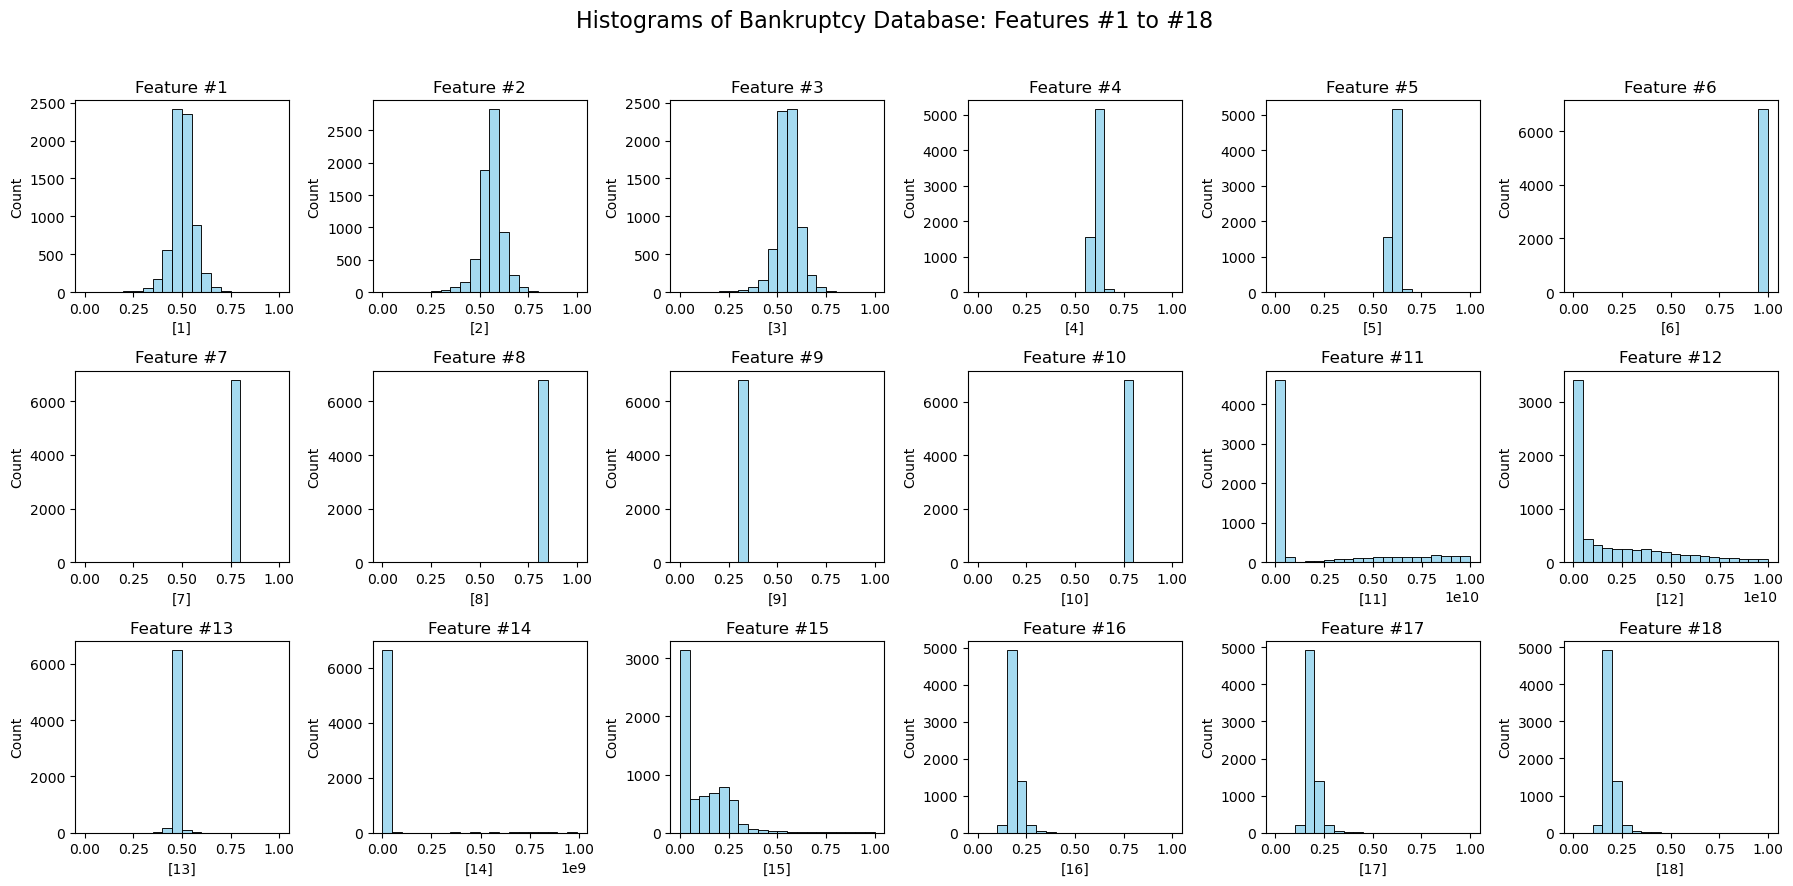

In [5]:
# Plot histograms for features #1 to #18
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i in range(1, 19):
    sns.histplot(bankruptcyDB.iloc[:, i], bins=20, ax=axes[(i-1)//6, (i-1)%6], color='skyblue')
    axes[(i-1)//6, (i-1)%6].set_title(f"Feature #{i}")
fig.suptitle("Histograms of Bankruptcy Database: Features #1 to #18", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [6]:
scaler = MinMaxScaler()
bankruptcyDB.iloc[:, 1:] = scaler.fit_transform(bankruptcyDB.iloc[:, 1:])


C:\Users\prana\AppData\Local\Temp\ipykernel_21716\4093995215.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  bankruptcyDB.iloc[:, 1:] = scaler.fit_transform(bankruptcyDB.iloc[:, 1:])


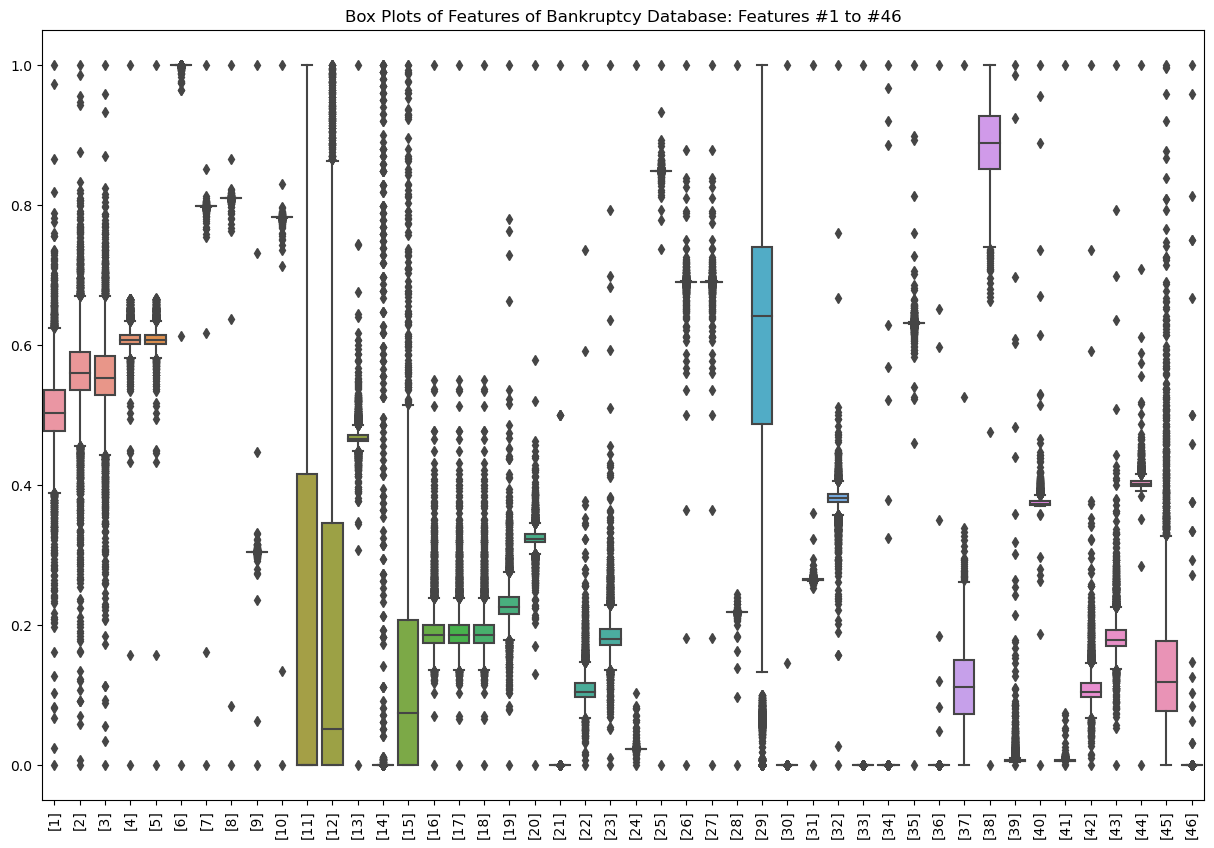

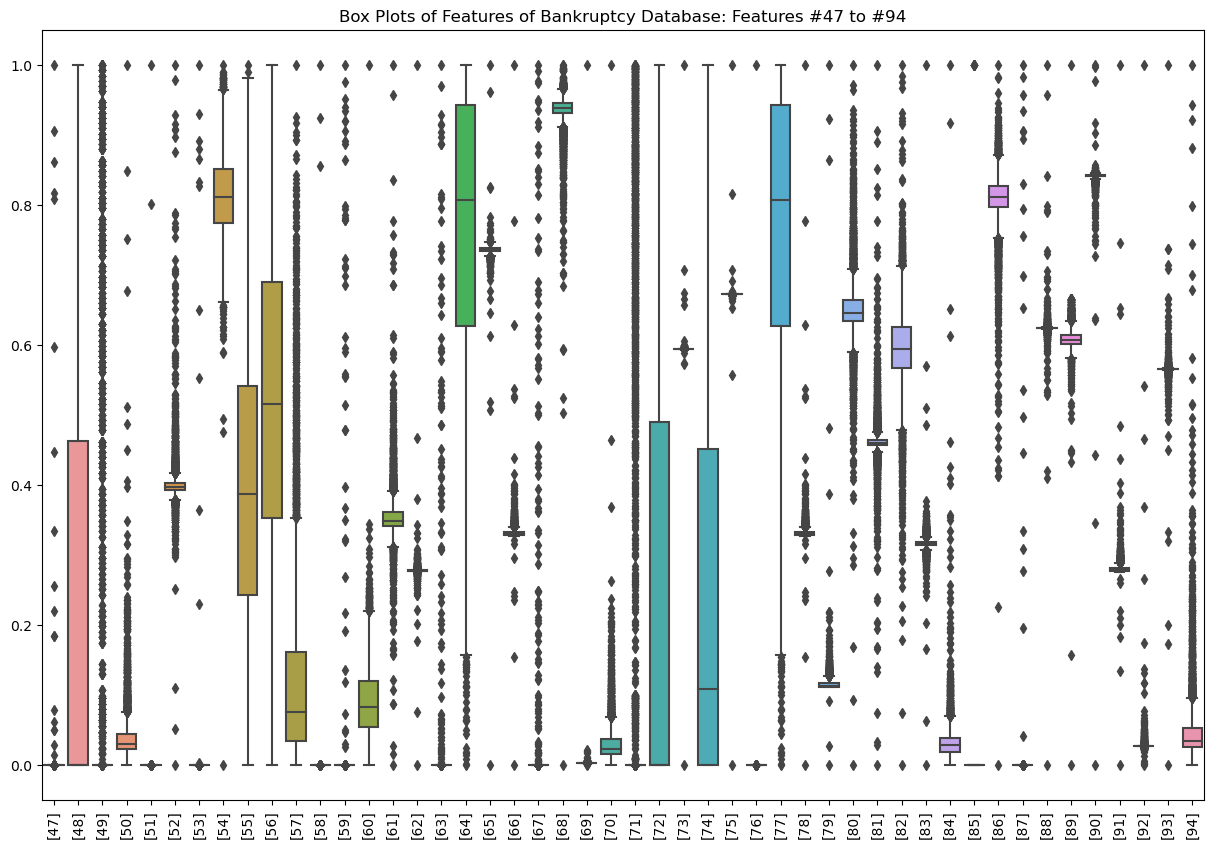

In [7]:
# Features #1 to #46
plt.figure(figsize=(15, 10))
sns.boxplot(data=bankruptcyDB.iloc[:, 1:47])
plt.title("Box Plots of Features of Bankruptcy Database: Features #1 to #46")
plt.xticks(rotation=90)
plt.show()

# Features #47 to #94
plt.figure(figsize=(15, 10))
sns.boxplot(data=bankruptcyDB.iloc[:, 47:])
plt.title("Box Plots of Features of Bankruptcy Database: Features #47 to #94")
plt.xticks(rotation=90)
plt.show()


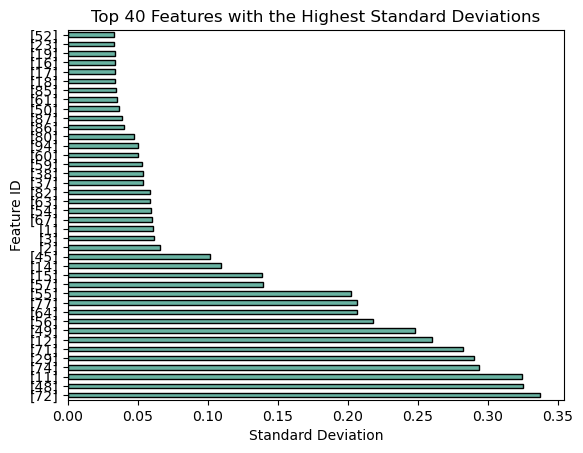

In [8]:
std_Columns = bankruptcyDB.iloc[:, 1:].std()
top_40_std = std_Columns.nlargest(40)
top_40_std.plot(kind='barh', color="#69b3a2", edgecolor='black')
plt.xlabel("Standard Deviation")
plt.ylabel("Feature ID")
plt.title("Top 40 Features with the Highest Standard Deviations")
plt.show()


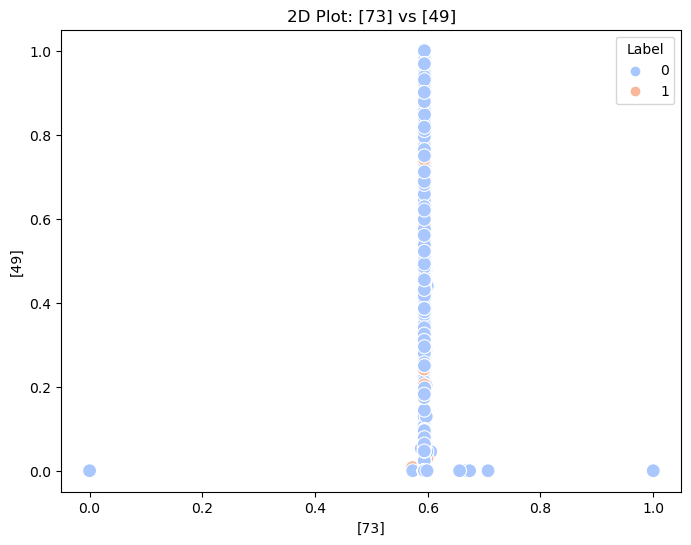

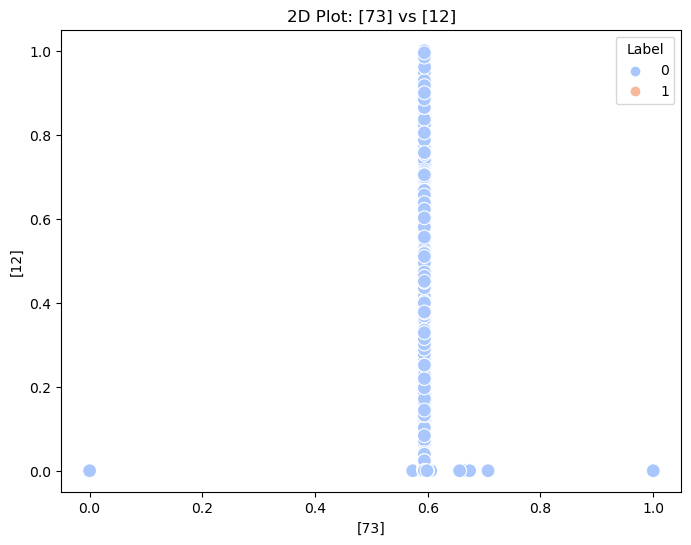

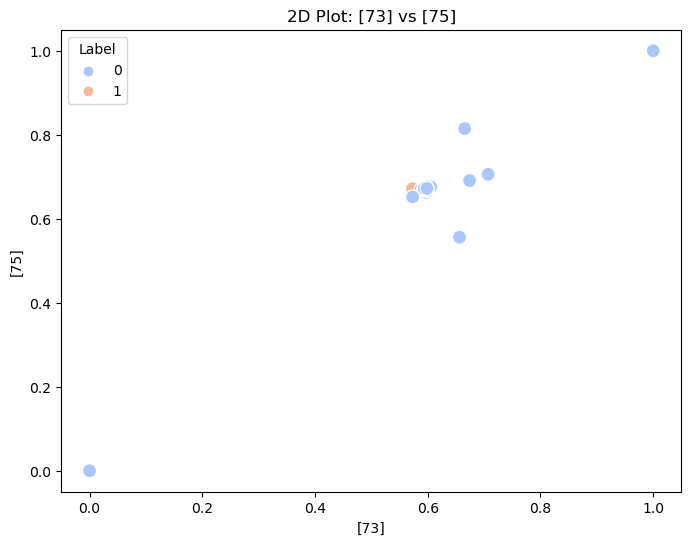

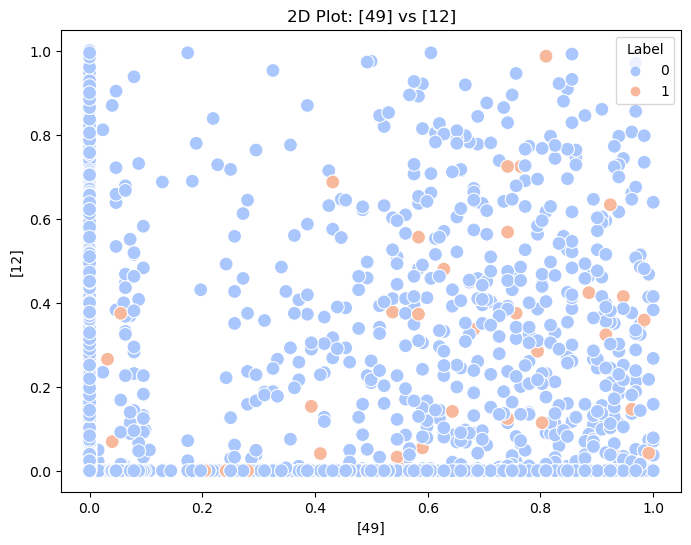

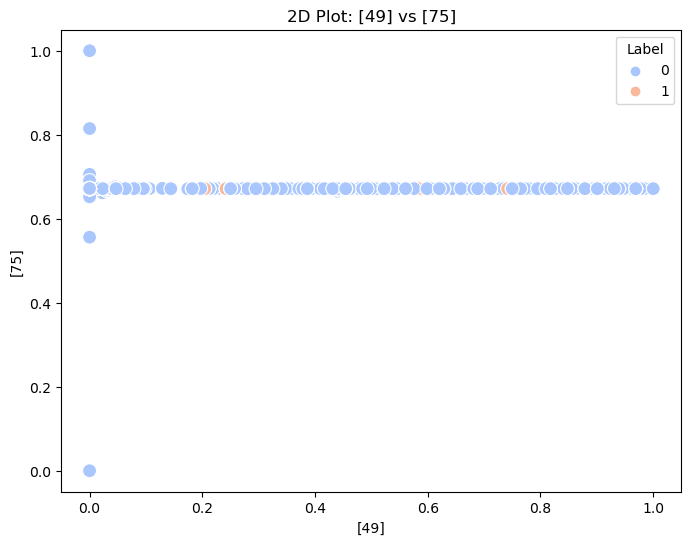

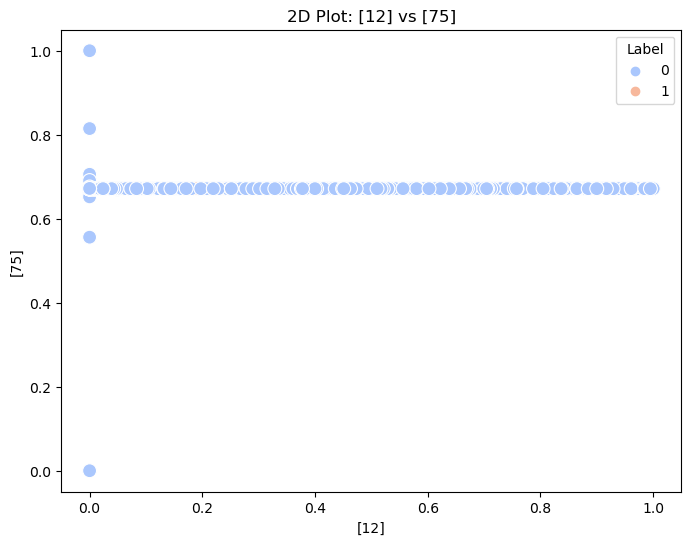

In [9]:
def plot_2d(db, x_col, y_col):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=db[x_col], y=db[y_col], hue=db['label'], palette='coolwarm', s=100)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"2D Plot: {x_col} vs {y_col}")
    plt.legend(title='Label')
    plt.show()

# Features with the highest standard deviations
selectedCols = ['[73]', '[49]', '[12]', '[75]']
for i in range(len(selectedCols)):
    for j in range(i+1, len(selectedCols)):
        plot_2d(bankruptcyDB, selectedCols[i], selectedCols[j])


In [10]:
def perform_classification(train_set, test_set, model_type):
    X_train = train_set.drop('label', axis=1)
    y_train = train_set['label']
    X_test = test_set.drop('label', axis=1)
    y_test = test_set['label']

    if model_type == "DT":
        model = DecisionTreeClassifier(min_samples_leaf=5, ccp_alpha=0.01)
    elif model_type == "SVM":
        model = SVC(kernel='sigmoid', C=0.5)

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)
    
    return model, conf_mat, report

# Split the data
X = bankruptcyDB.drop('label', axis=1)
y = bankruptcyDB['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

train_set_original = pd.concat([X_train, y_train], axis=1)
test_set_original = pd.concat([X_test, y_test], axis=1)

# Perform classification
model_DT_original, confMat_DT_Origin, report_DT_Origin = perform_classification(train_set_original, test_set_original, "DT")
model_SVM_original, confMat_SVM_Origin, report_SVM_Origin = perform_classification(train_set_original, test_set_original, "SVM")


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\metr

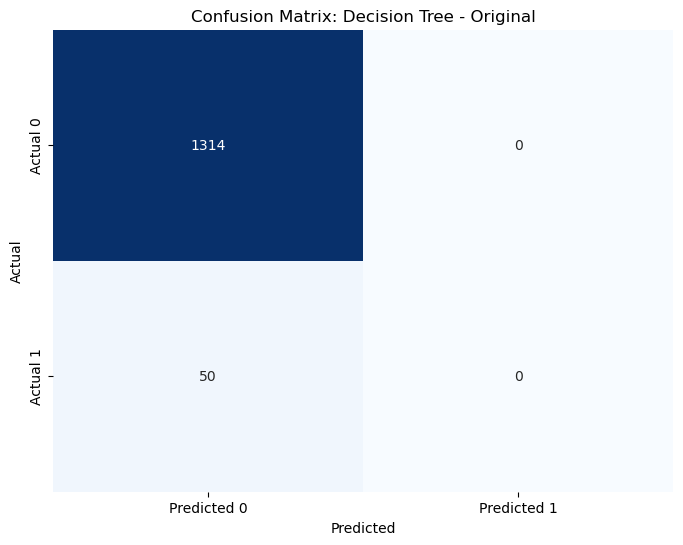

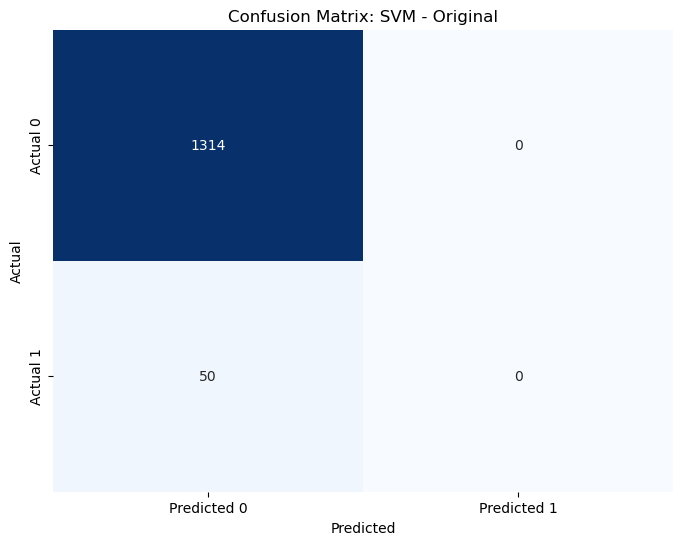


Decision Tree Metrics:
Accuracy: 0.9633
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

SVM Metrics:
Accuracy: 0.9633
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [11]:
# Confusion Matrix
import seaborn as sns

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(confMat_DT_Origin, "Confusion Matrix: Decision Tree - Original")
plot_confusion_matrix(confMat_SVM_Origin, "Confusion Matrix: SVM - Original")

# Metrics
def print_metrics(report, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"Precision: {report['1']['precision']:.4f}")
    print(f"Recall: {report['1']['recall']:.4f}")
    print(f"F1 Score: {report['1']['f1-score']:.4f}")

print_metrics(report_DT_Origin, "Decision Tree")
print_metrics(report_SVM_Origin, "SVM")


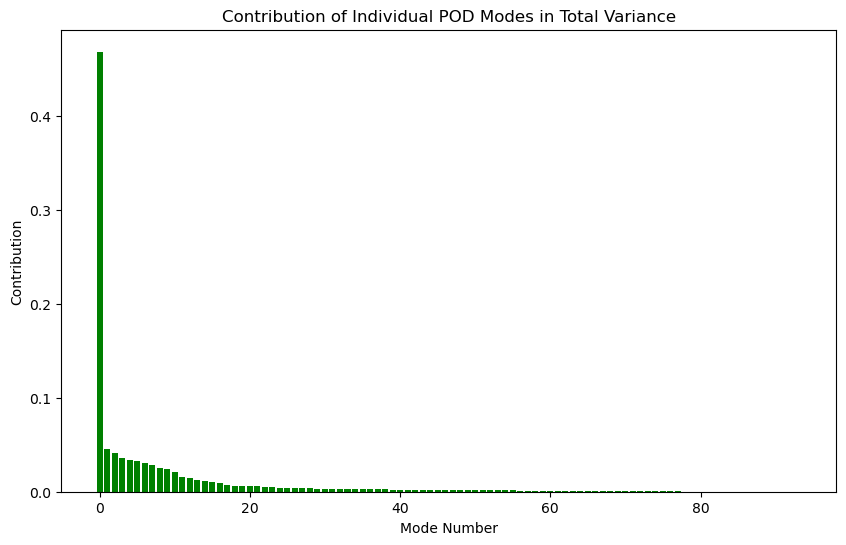

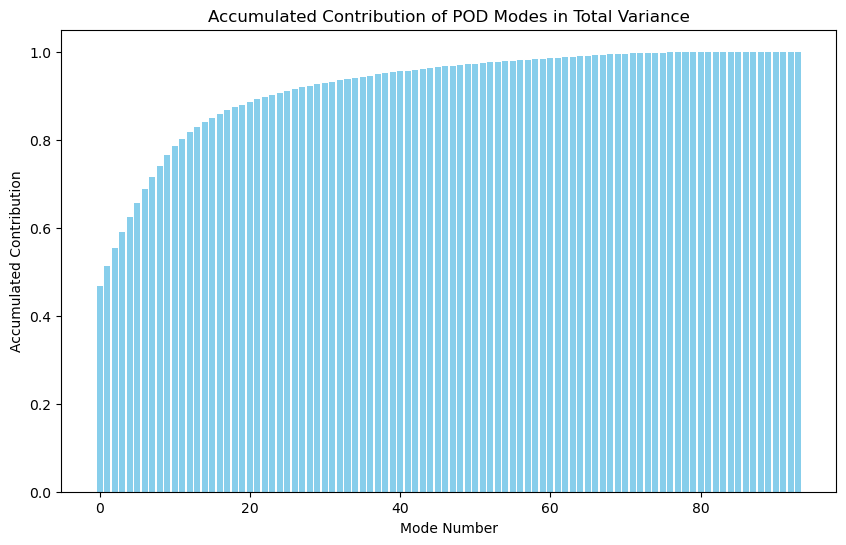

In [12]:
# POD using SVD
X_normalized = bankruptcyDB.iloc[:, 1:].values
U, s, Vt = svd(X_normalized)

# Normalize POD weights
normSigma = s / np.sum(s)

# Plot POD contribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(normSigma)), normSigma, color='green')
plt.xlabel('Mode Number')
plt.ylabel('Contribution')
plt.title('Contribution of Individual POD Modes in Total Variance')
plt.show()

# Plot accumulated contribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(np.cumsum(normSigma))), np.cumsum(normSigma), color='skyblue')
plt.xlabel('Mode Number')
plt.ylabel('Accumulated Contribution')
plt.title('Accumulated Contribution of POD Modes in Total Variance')
plt.show()
